In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1" #! specify gpu here

import open3d as o3d # this might need to run before torch


import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import json
import warnings
from pathlib import Path
import random
import base64
from io import BytesIO
import cv2
import vision_pipeline.obb
import imagesize
# from scipy import ndimage
import natsort
from PIL import Image as PILImage
from PIL import ImageDraw, ImageFilter
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from rich import print
from types import SimpleNamespace
import pickle
import imutils

# ros package
from context_action_framework.types import Detection, Label, Module, Camera
from sensor_msgs.msg import Image, CameraInfo # CameraInfo needed for pickle

# local imports
from vision_pipeline.helpers import Struct, make_valid_poly, img_to_camera_coords, scale_img
from context_action_framework.graph_relations import GraphRelations, exists_detection, compute_iou
from vision_pipeline.work_surface_detection_opencv import WorkSurfaceDetection
from vision_pipeline.object_detection_model import ObjectDetectionModel
from vision_pipeline.object_detection import ObjectDetection
from vision_pipeline.object_reid import ObjectReId

from vision_pipeline.config import load_config

from gap_detection.gap_detector_clustering import GapDetectorClustering

import rospy


rospy.init_node("test_node")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
depth_rescaling_factor = 1/1000

config = load_config(os.path.expanduser("~/vision_pipeline/config.yaml"))

config.reid = False

config.realsense.debug_clustering = True

# pretend to use Basler camera
camera_type = Camera.realsense
# camera_name = camera_type.name

camera_config = config.realsense

camera_config.enable_topic = "set_sleeping" # basler camera specific
camera_config.enable_camera_invert = True # enable = True, but the topic is called set_sleeping, so the inverse
camera_config.use_worksurface_detection = True

model = ObjectDetectionModel(config.obj_detection)

object_detection = ObjectDetection(config, 
                                        camera_config,
                                        model=model,
                                        object_reid=None,
                                        camera=camera_type,
                                        frame_id="",
                                        use_ros=False)

gap_detector = GapDetectorClustering(config)

config:
{
    'node_name': 'vision',
    'reid': False,
    'basler': {
        'target_fps': 2,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 180,
        'topic': 'basler',
        'camera_node': '/basler',
        'image_topic': 'image_rect_color',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_graph_img': True,
        'has_depth': False,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'table_name': 'table_vision',
        'parent_frame': 'vision_table_zero',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'work_surface_ignore_border_width': 50,
        'show_work_surface_detection': False,
        'use_worksurface_detection': True,
        'debug_work_surface_detection': False
    },
    'realsense': {
        'target_fps': 2,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 0,
        'topic': 'realsense',
        'camera_node': '/realsense',
        'image_topic': 'color/image_raw',
        'info_topic': 'color/camera_info',
        'depth_topic': 'aligned_depth_to_color/image_raw',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_depth_img': True,
        'publish_cluster_img': True,
        'publish_graph_img': False,
        'has_depth': True,
        'compute_gaps': False,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'camera_height': 0.2,
        'parent_frame': 'panda_2/realsense',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'calibration_file': '~/vision_pipeline/realsense_calib/realsense_calib.yaml',
        'debug_clustering': False
    },
    'obj_detection': {
        'debug': True,
        'model': 'yolov8',
        'yolact_dataset_file': '~/vision_pipeline/data_limited/yolact/2023-07-18_firealarms_hcas/dataset.json',
        'yolact_score_threshold': 0.5,
        'yolov8_model_file': '~/vision_pipeline/data_limited/yolov8/output_2024-06-06_20000_all/best.pt',
        'yolov8_score_threshold': 0.5,
        'superglue_templates': '~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped',
        'superglue_model_file': '~/superglue_training/output/train/2023-11-18_superglue_model/weights/best.pt',
        'superglue_match_threshold': 0.5,
        'rotation_median_filter': True,
        'superglue_visualise_to_file': False,
        'classifier_model_file': 
'~/vision_pipeline/data_limited/classifier/2024-07-03__08-33_classify/lightning_logs/version_0/checkpoints/epoch=31
9-step=319.ckpt',
        'classifier_threshold': 0.2
    }
}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.learning_rate 1e-05

model.batch_size 64

model.freeze_backbone False

curr_weights_path /home/docker/superglue_training/output/train/2023-11-18_superglue_model/weights/best.pt

Loaded SuperPoint model
Loaded SuperGlue model ("/home/docker/superglue_training/output/train/2023-11-18_superglue_model/weights/best.pt" weights)


100%|██████████| 61/61 [00:00<00:00, 152.93it/s]


Loaded superglue templates 61

In [17]:
images_dir = Path(os.path.expanduser("~/datasets2/reconcycle/2024-04-30_realsense_hcas"))

file_name_without_ext = "0002"

image_paths = list(images_dir.glob('*.jpg'))
image_paths = [path for path in image_paths if "viz" not in str(path.stem)]
image_paths = natsort.os_sorted(image_paths)

file_names_without_ext = [path.stem for path in image_paths]

# print("file_names_without_ext", file_names_without_ext)

def load_depth_data_from_filename(file_name_without_ext, images_dir):

    image_path = images_dir / Path(file_name_without_ext + ".jpg")
    camera_info_path = images_dir / Path(file_name_without_ext + "_camera_info.pickle")
    depth_path = images_dir / Path(file_name_without_ext + "_depth.npy")
    image_viz_path = images_dir / Path(file_name_without_ext + "_depth_viz.jpg")

    colour_img = cv2.imread(str(image_path))
    depth_vis_img = cv2.imread(str(image_viz_path))

    depth_img = np.load(depth_path)
    pickleFile = open(camera_info_path, 'rb')
    camera_info = pickle.load(pickleFile)

    depth_img = depth_img * depth_rescaling_factor

    return colour_img, depth_vis_img, depth_img, camera_info

In [22]:
def run_gap_detection(colour_img, depth_img, camera_info):
    labelled_img, detections, markers, poses, graph_img, graph_relations = object_detection.get_prediction(colour_img, depth_img=depth_img, worksurface_detection=None, extra_text=None, camera_info=camera_info, use_tracker=False, use_classify=True)

    if depth_img is not None:
        gaps, cluster_img, device_mask, depth_masked_ma, depth_scaled, depth_scaled_masked \
            = gap_detector.lever_detector(
                colour_img,
                depth_img,
                detections,
                graph_relations,
                camera_info
            )
        
        return labelled_img, depth_scaled, cluster_img

classify: kalo, 03, conf: 0.9104254245758057

elapsed_time_classify_and_rot 0.01876131445169449

depth mean 0.3049, median 0.304

depth mean 0.30169, median 0.302

depth mean 0.29646, median 0.297

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 0

TODO: implement removing of outliers

gap detector, depth_min: 0.28800000000000003

gap detector, depth_min_nonzero: 0.28800000000000003

gap detector, depth_median_nonzero: 0.302

gap detector, depth_max: 0.322

gap detector, num clusters: 3

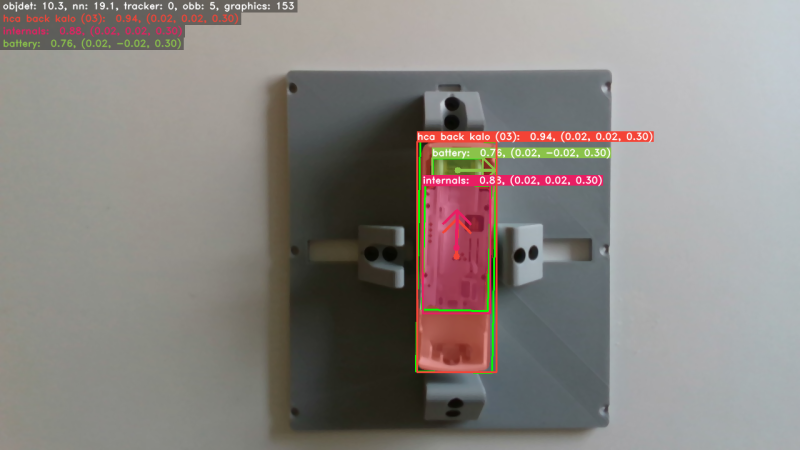

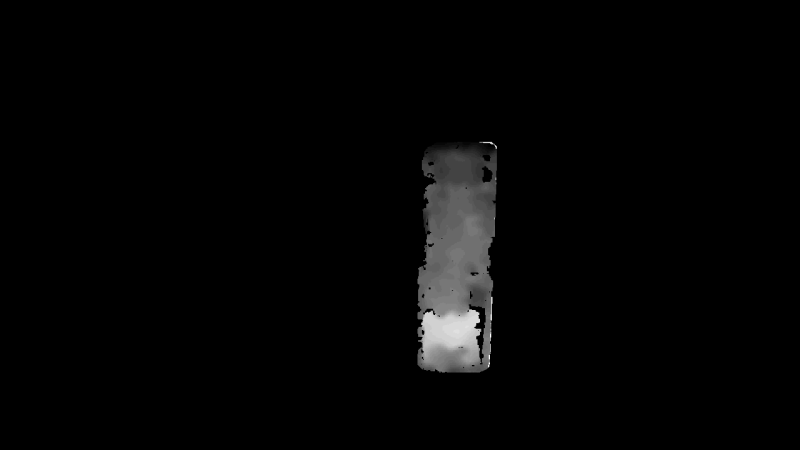

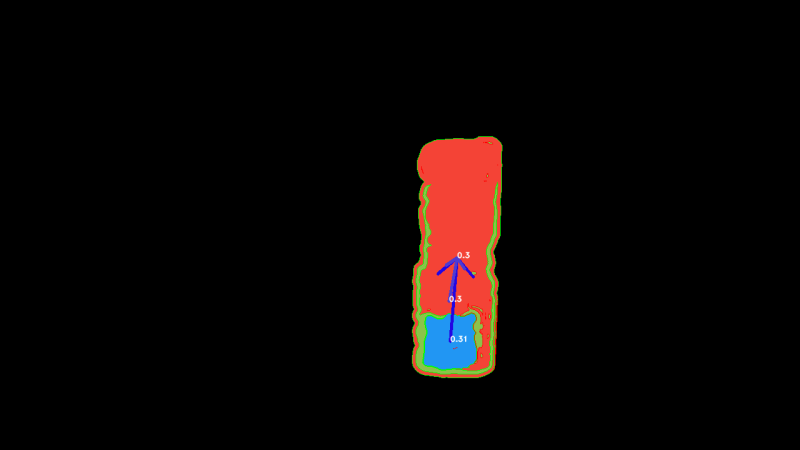

classify: kalo, 03, conf: 0.8571254014968872

elapsed_time_classify_and_rot 0.018467983230948448

depth mean 0.30419, median 0.303

depth mean 0.30164, median 0.302

depth mean 0.29644, median 0.297

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 860

TODO: implement removing of outliers

gap detector, depth_min: 0.28800000000000003

gap detector, depth_min_nonzero: 0.28800000000000003

gap detector, depth_median_nonzero: 0.302

gap detector, depth_max: 0.322

gap detector, num clusters: 11

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


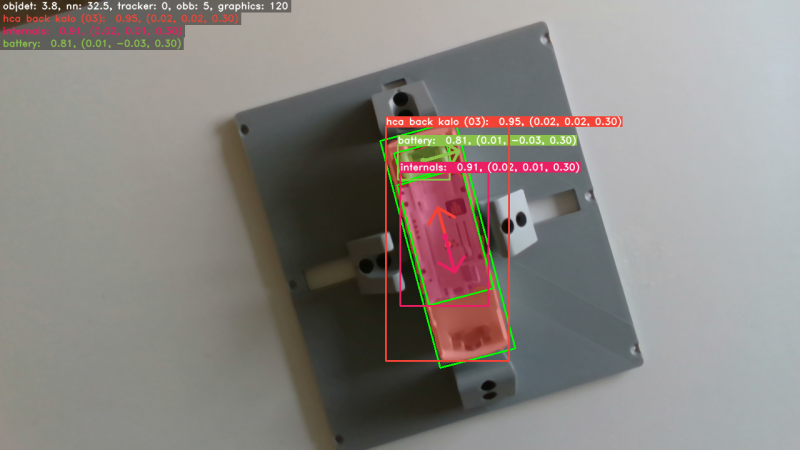

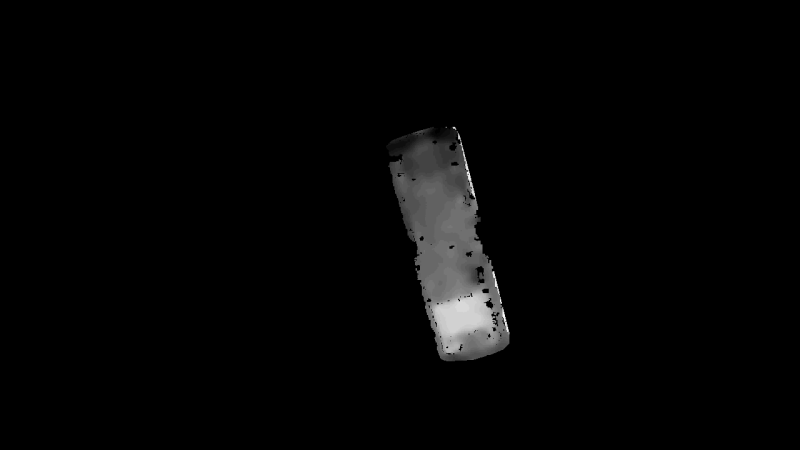

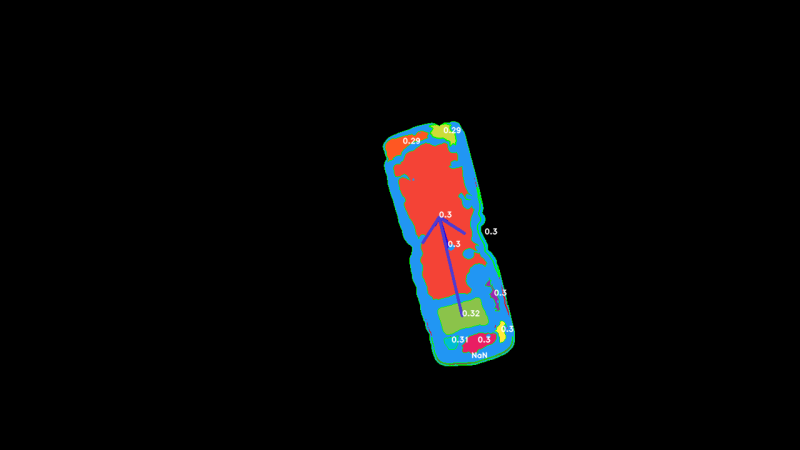

classify: kalo, 03, conf: 0.5259996652603149

elapsed_time_classify_and_rot 0.015731701627373695

depth mean 0.30365, median 0.303

depth mean 0.30098, median 0.301

depth mean 0.29627, median 0.296

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 21014

TODO: implement removing of outliers

gap detector, depth_min: 0.28800000000000003

gap detector, depth_min_nonzero: 0.28800000000000003

gap detector, depth_median_nonzero: 0.301

gap detector, depth_max: 0.321

gap detector, num clusters: 7

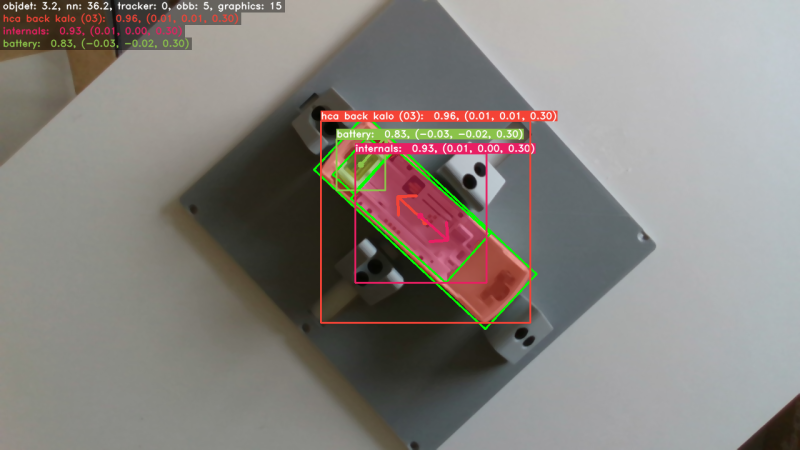

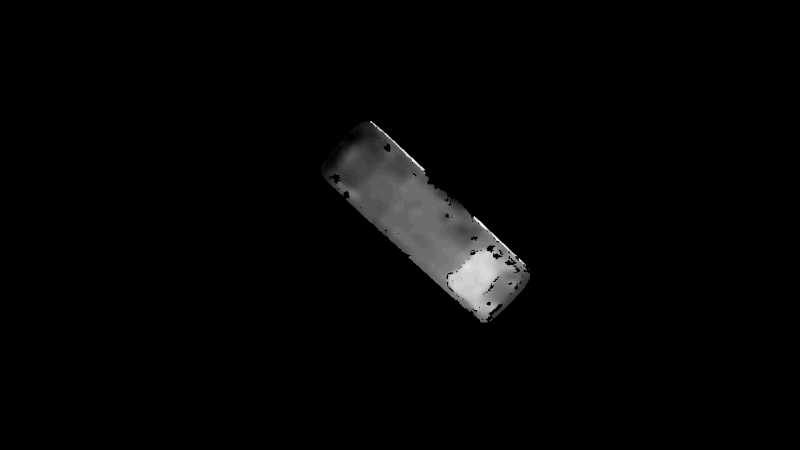

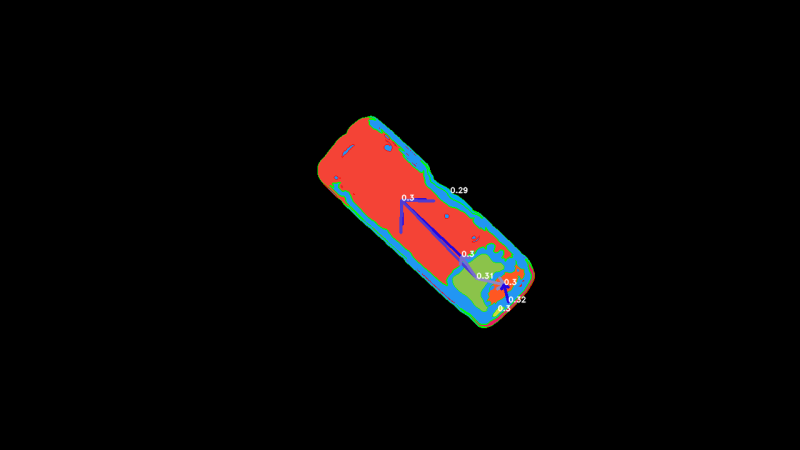

classify: kalo, 03, conf: 0.870112419128418

elapsed_time_classify_and_rot 0.017133906483650208

depth mean 0.30463, median 0.303

depth mean 0.3018, median 0.302

depth mean 0.29917, median 0.299

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 34893

TODO: implement removing of outliers

gap detector, depth_min: 0.289

gap detector, depth_min_nonzero: 0.289

gap detector, depth_median_nonzero: 0.302

gap detector, depth_max: 0.325

gap detector, num clusters: 7

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


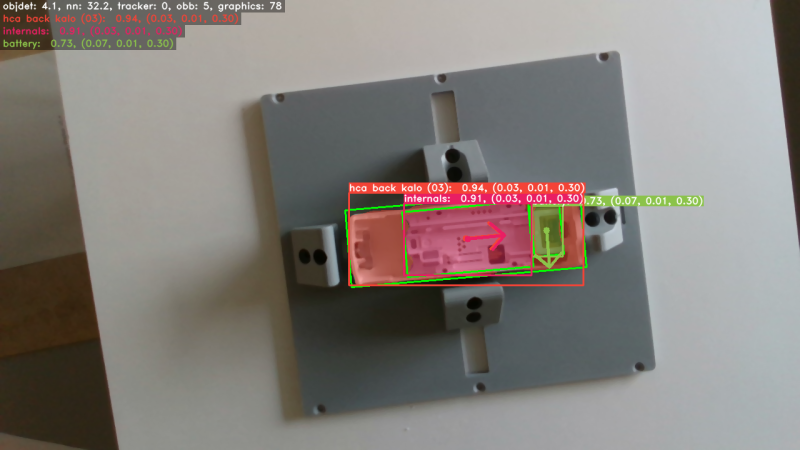

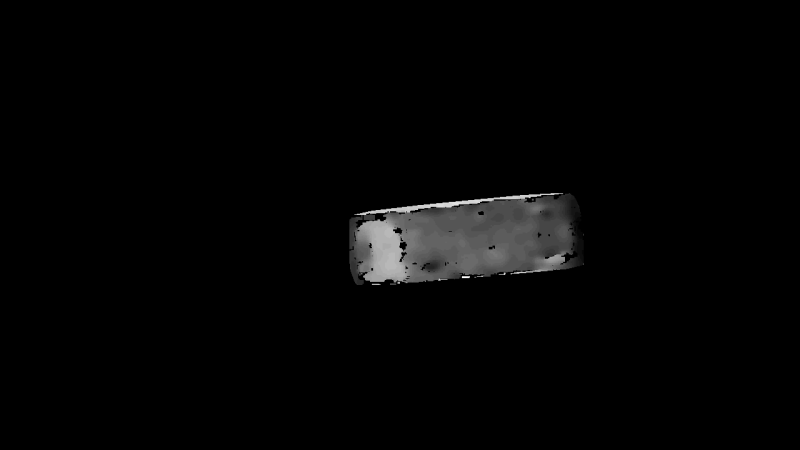

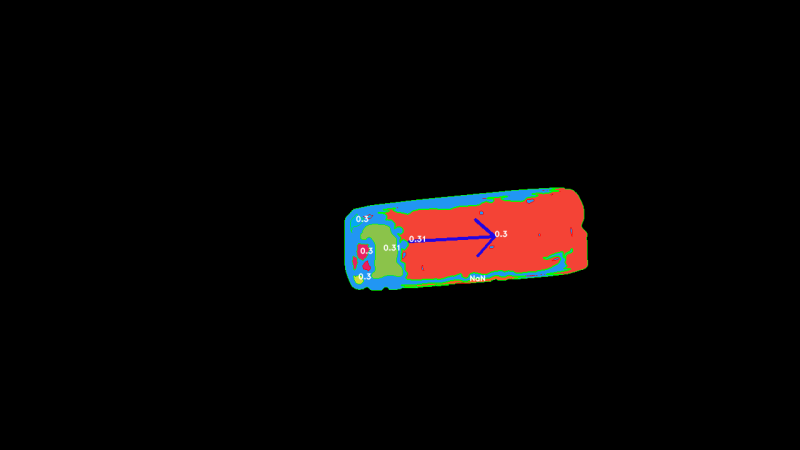

classify: kalo, 03, conf: 0.23507152497768402

elapsed_time_classify_and_rot 0.017278612591326237

depth mean 0.38038, median 0.38

depth mean 0.37699, median 0.377

depth mean 0.37359, median 0.373

median depth: 0.398

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 155961

TODO: implement removing of outliers

gap detector, depth_min: 0.367

gap detector, depth_min_nonzero: 0.367

gap detector, depth_median_nonzero: 0.377

gap detector, depth_max: 0.396

gap detector, num clusters: 6

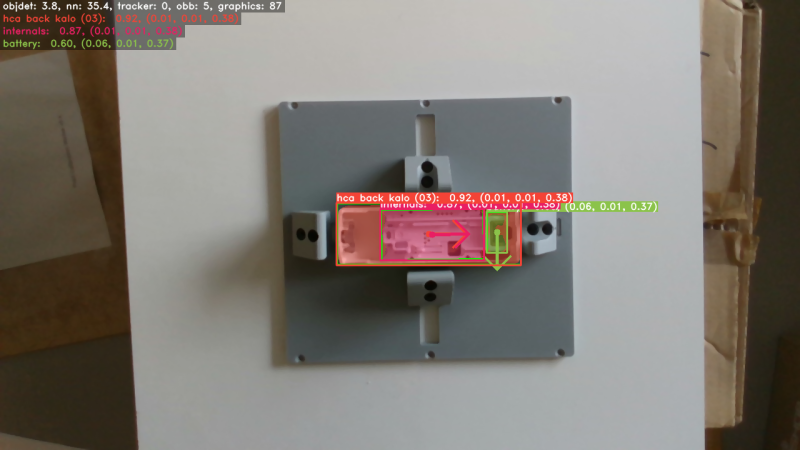

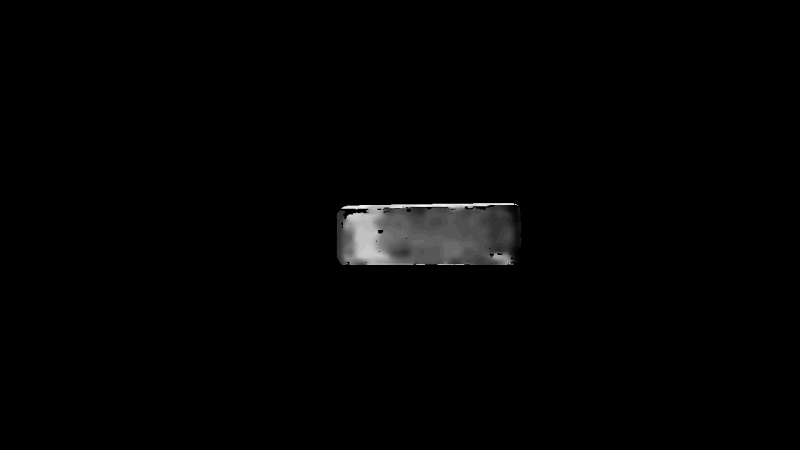

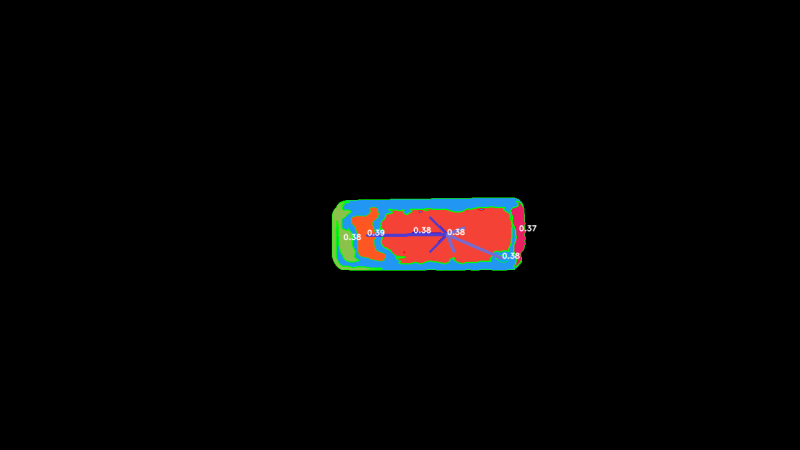

classify conf too low: 0.16388586163520813, hca_back_06

elapsed_time_classify_and_rot 0.015623819082975388

depth mean 0.37766, median 0.378

depth mean 0.37559, median 0.376

depth mean 0.37031, median 0.37

median depth: 0.397

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 93709

TODO: implement removing of outliers

gap detector, depth_min: 0.36

gap detector, depth_min_nonzero: 0.36

gap detector, depth_median_nonzero: 0.376

gap detector, depth_max: 0.392

gap detector, num clusters: 6

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


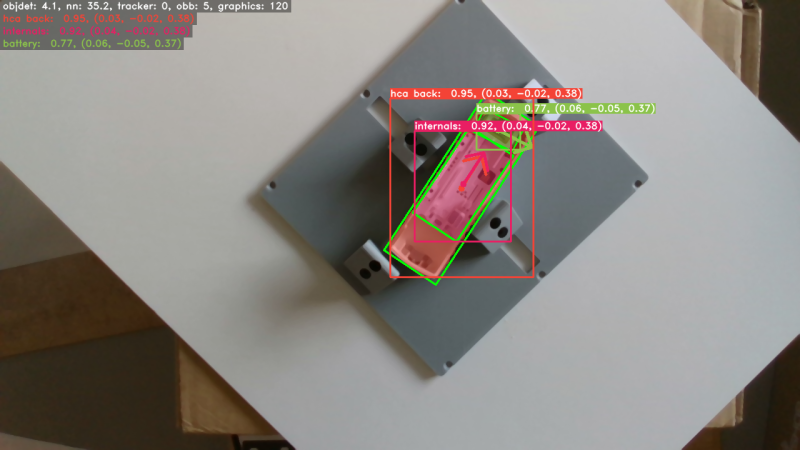

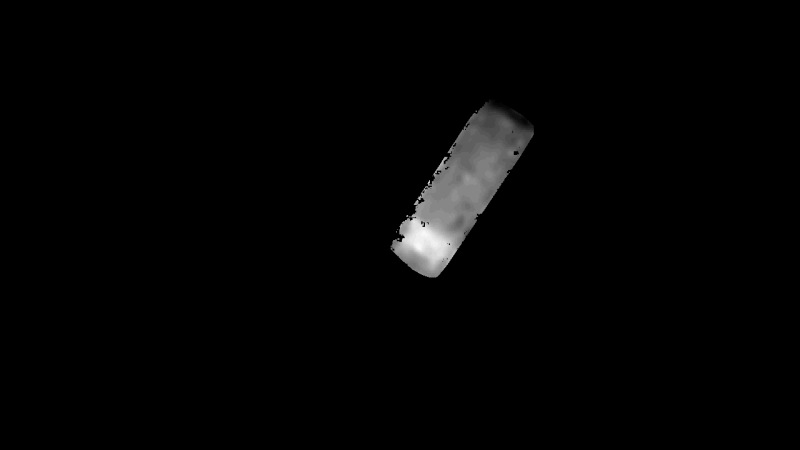

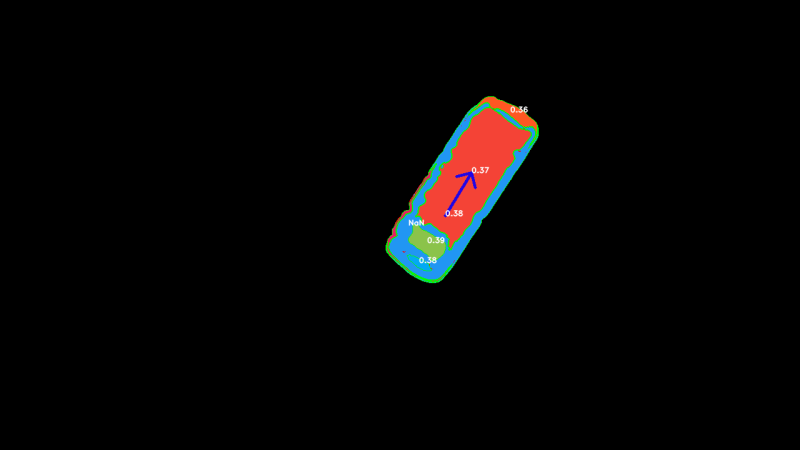

classify: kalo, 03, conf: 0.3501581847667694

elapsed_time_classify_and_rot 0.014901533722877502

depth mean 0.37832, median 0.379

depth mean 0.37627, median 0.376

depth mean 0.3713, median 0.371

median depth: 0.397

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 3931

TODO: implement removing of outliers

gap detector, depth_min: 0.363

gap detector, depth_min_nonzero: 0.363

gap detector, depth_median_nonzero: 0.377

gap detector, depth_max: 0.398

gap detector, num clusters: 4

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


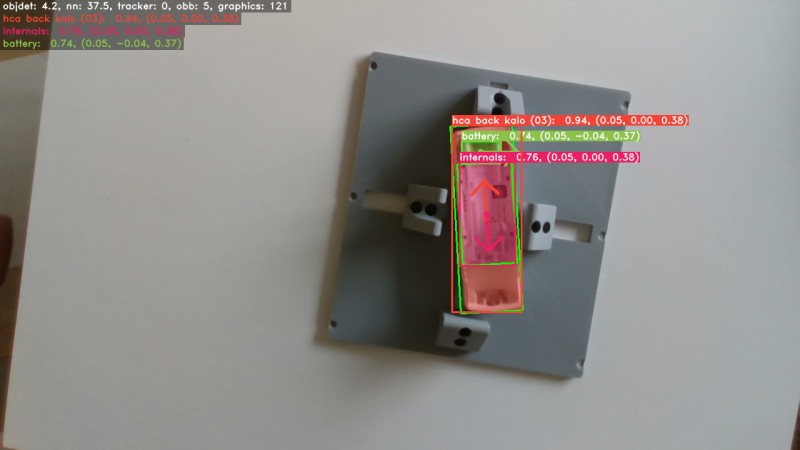

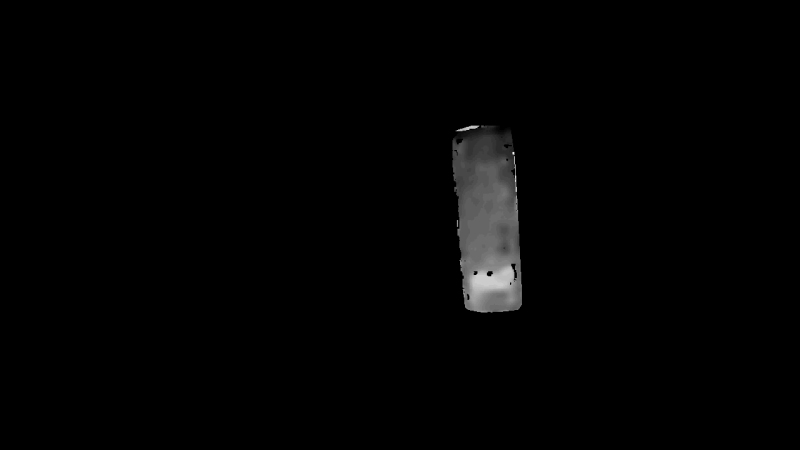

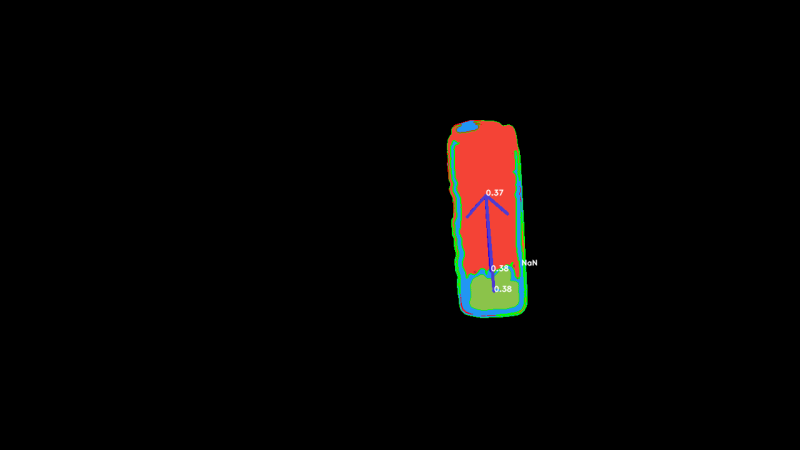

classify: kalo, 03, conf: 0.30045902729034424

elapsed_time_classify_and_rot 0.020294426009058952

depth mean 0.37843, median 0.378

depth mean 0.37619, median 0.376

depth mean 0.37189, median 0.372

median depth: 0.398

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 39530

TODO: implement removing of outliers

gap detector, depth_min: 0.36

gap detector, depth_min_nonzero: 0.36

gap detector, depth_median_nonzero: 0.376

gap detector, depth_max: 0.399

gap detector, num clusters: 8

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


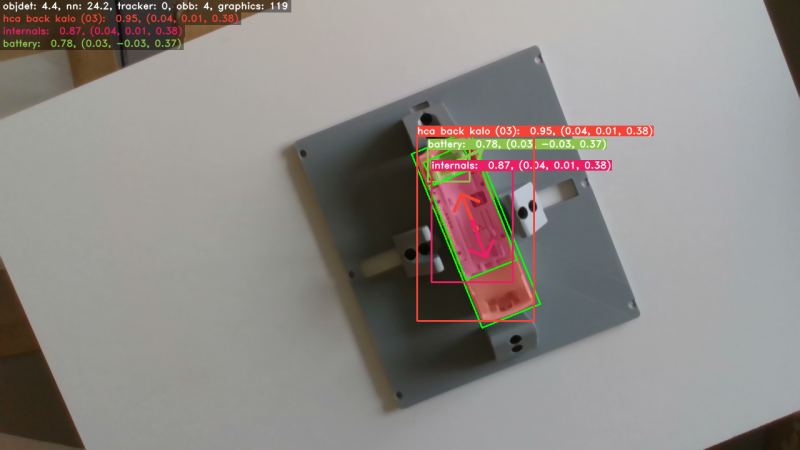

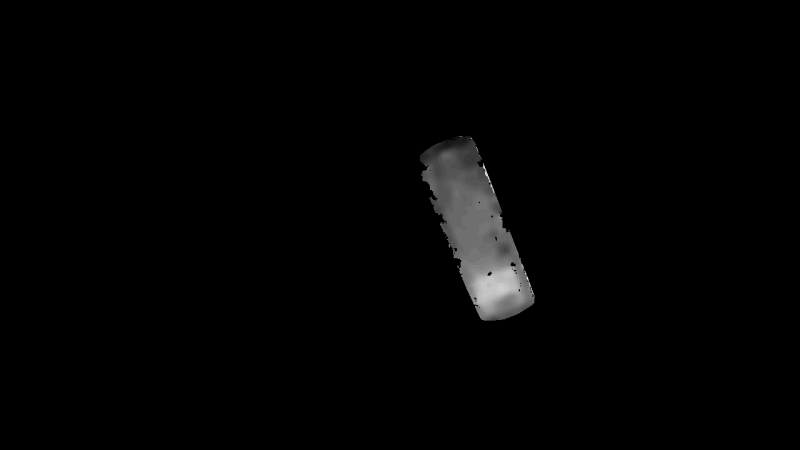

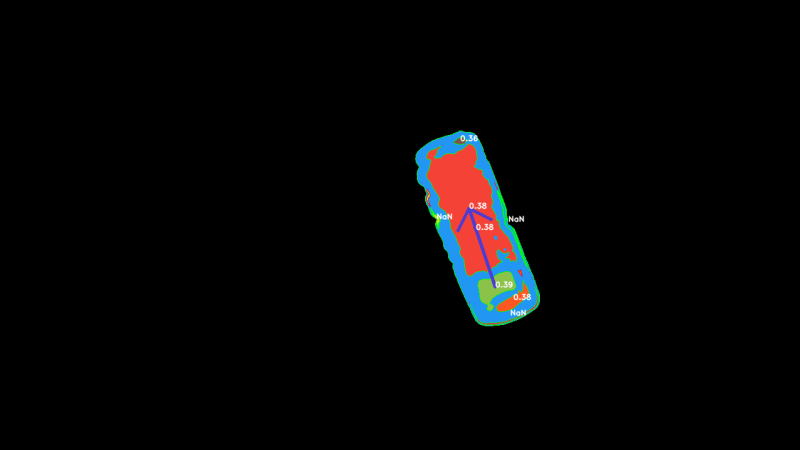

classify: kalo, 03, conf: 0.33168500661849976

elapsed_time_classify_and_rot 0.015453066676855087

depth mean 0.37631, median 0.376

depth mean 0.37369, median 0.374

depth mean 0.36973, median 0.37

median depth: 0.399

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 91281

TODO: implement removing of outliers

gap detector, depth_min: 0.361

gap detector, depth_min_nonzero: 0.361

gap detector, depth_median_nonzero: 0.374

gap detector, depth_max: 0.394

gap detector, num clusters: 4

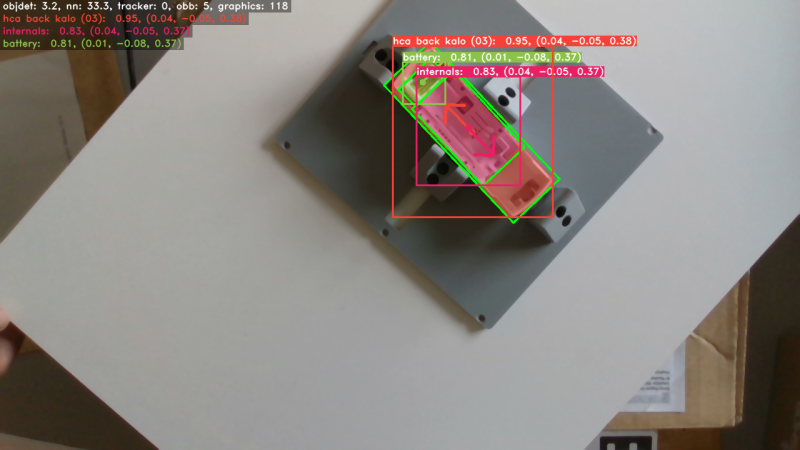

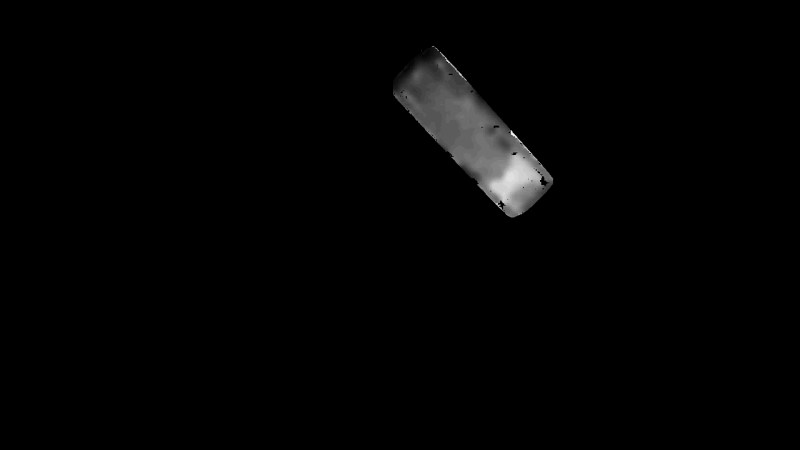

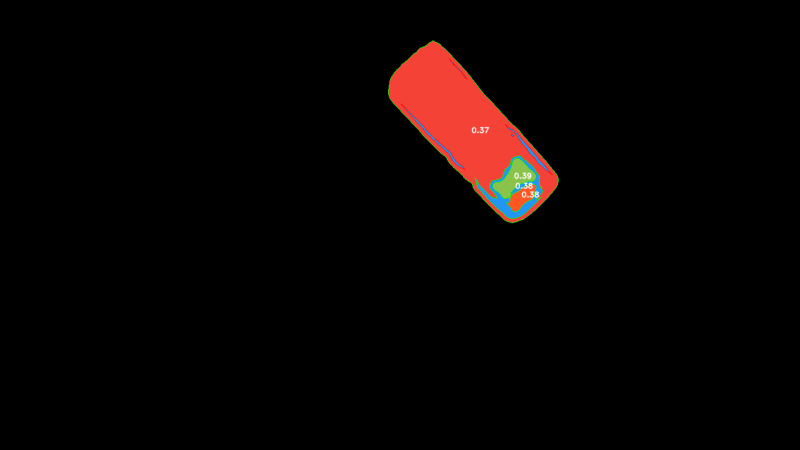

classify: techem, 04.1, conf: 0.27479231357574463

elapsed_time_classify_and_rot 0.015042193233966827

depth mean 0.37872, median 0.379

depth mean 0.37579, median 0.376

depth mean 0.37258, median 0.372

median depth: 0.398

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 91620

TODO: implement removing of outliers

gap detector, depth_min: 0.359

gap detector, depth_min_nonzero: 0.359

gap detector, depth_median_nonzero: 0.376

gap detector, depth_max: 0.396

gap detector, num clusters: 10

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


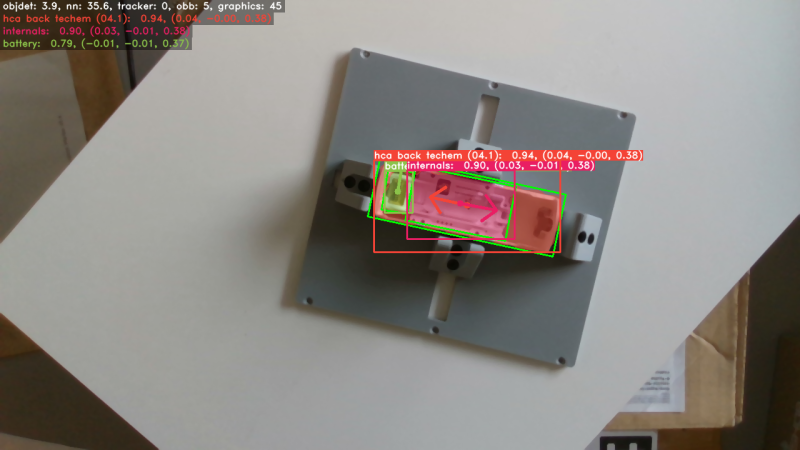

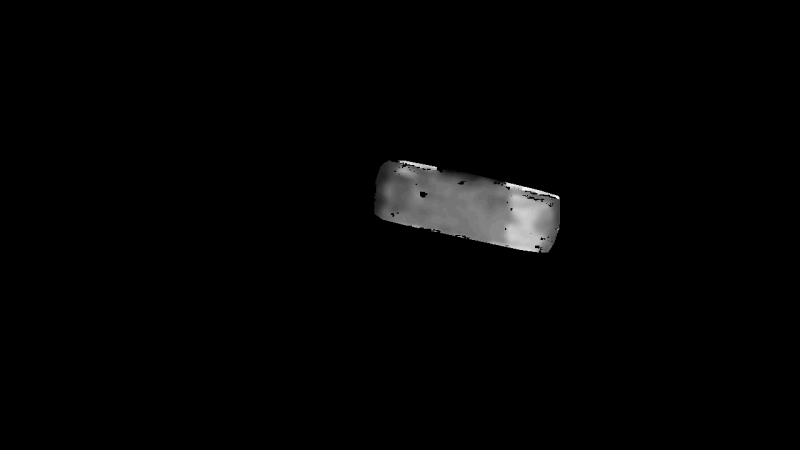

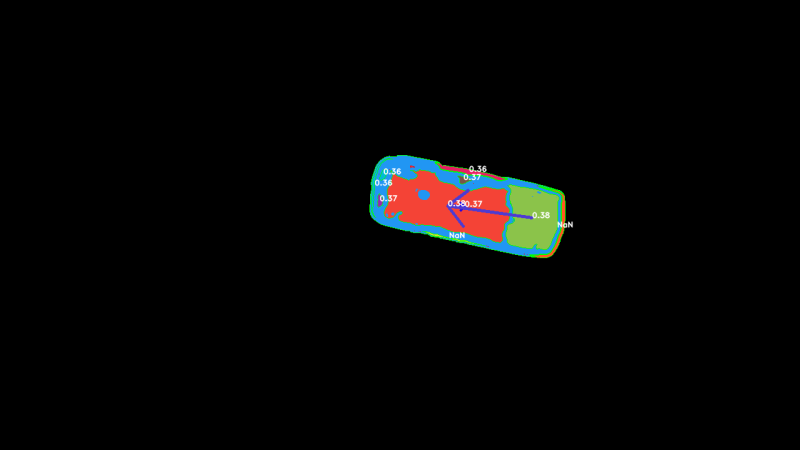

classify: caloric, 07, conf: 0.6477946043014526

elapsed_time_classify_and_rot 0.016354813240468502

depth mean 0.29785, median 0.295

depth mean 0.30181, median 0.302

depth mean 0.29897, median 0.3

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 0

TODO: implement removing of outliers

gap detector, depth_min: 0.28500000000000003

gap detector, depth_min_nonzero: 0.28500000000000003

gap detector, depth_median_nonzero: 0.301

gap detector, depth_max: 0.322

gap detector, num clusters: 13

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


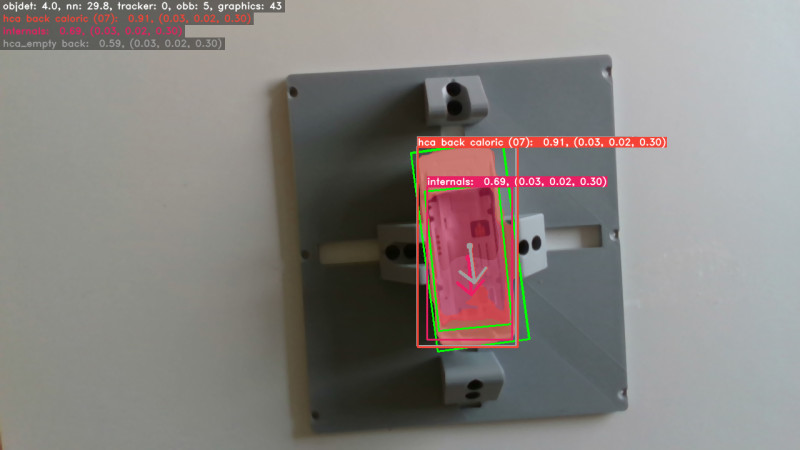

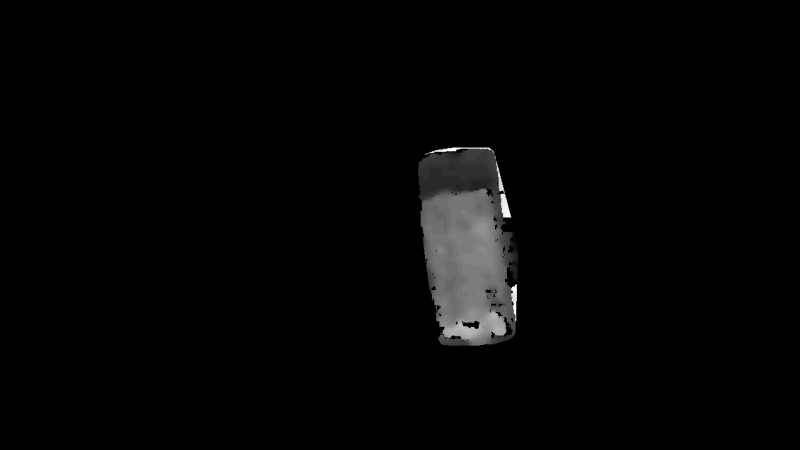

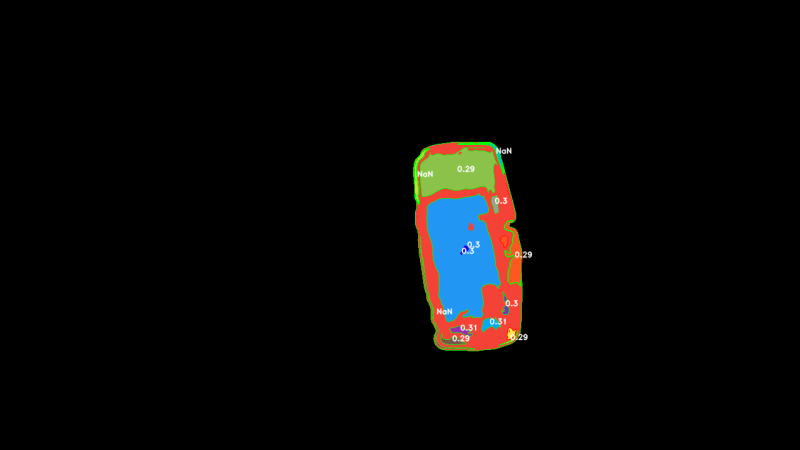

classify: caloric, 07, conf: 0.8536427021026611

classifier says face:  back (type: 0), but yolo says face: front

classify: caloric, 07, conf: 0.33961716294288635

elapsed_time_classify_and_rot 0.025582692585885525

depth mean 0.29807, median 0.294

depth mean 0.30221, median 0.303

depth mean 0.30036, median 0.299

depth mean 0.30034, median 0.299

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 0

TODO: implement removing of outliers

gap detector, depth_min: 0.28800000000000003

gap detector, depth_min_nonzero: 0.28800000000000003

gap detector, depth_median_nonzero: 0.302

gap detector, depth_max: 0.324

gap detector, num clusters: 14

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


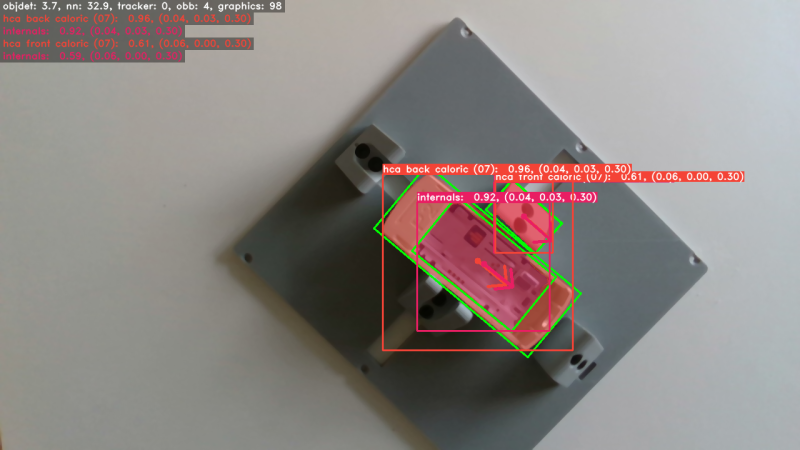

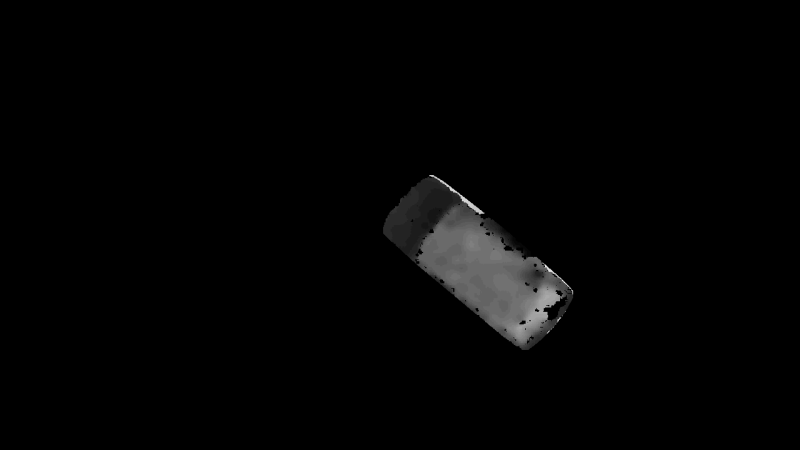

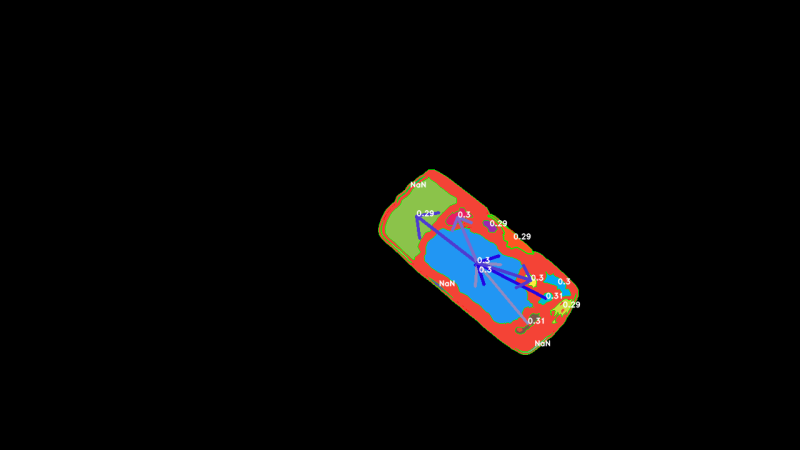

classify: caloric, 07, conf: 0.967256486415863

elapsed_time_classify_and_rot 0.026607170701026917

depth mean 0.29702, median 0.294

depth mean 0.30117, median 0.302

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 0

TODO: implement removing of outliers

gap detector, depth_min: 0.28500000000000003

gap detector, depth_min_nonzero: 0.28500000000000003

gap detector, depth_median_nonzero: 0.301

gap detector, depth_max: 0.322

gap detector, num clusters: 7

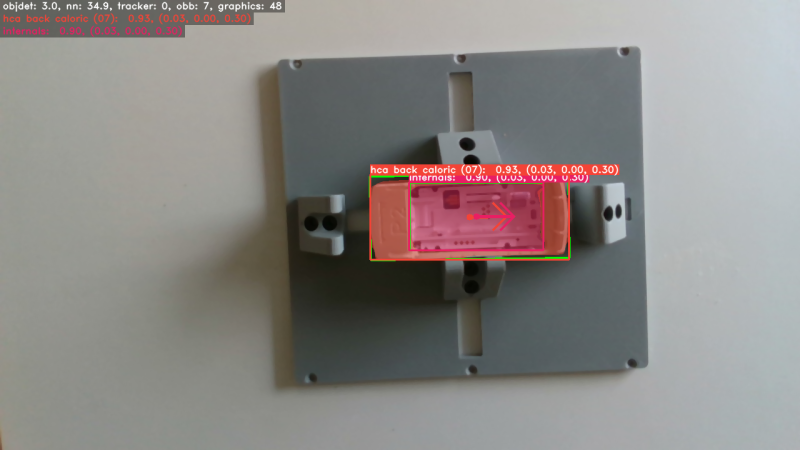

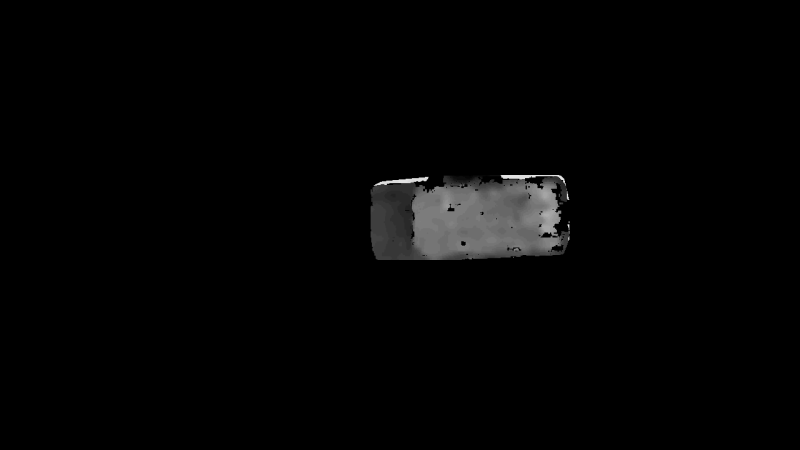

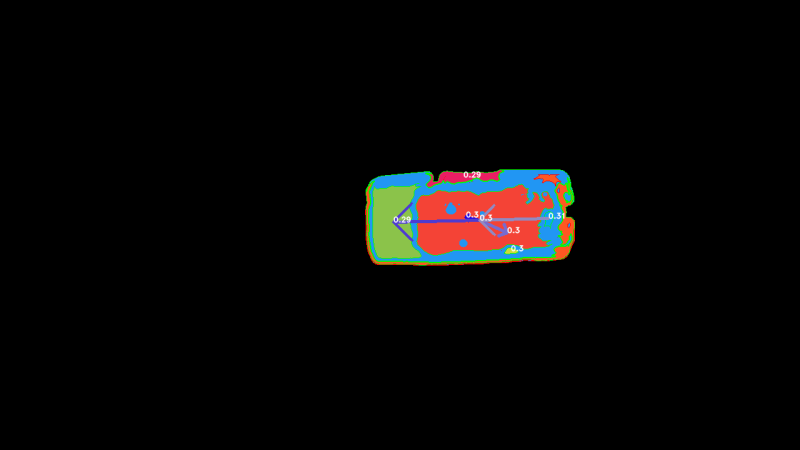

classify: caloric, 07, conf: 0.8128999471664429

elapsed_time_classify_and_rot 0.015239586122334003

depth mean 0.29581, median 0.295

depth mean 0.30165, median 0.302

depth mean 0.30362, median 0.305

depth mean 0.2996, median 0.294

median depth: 0.321

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 0

TODO: implement removing of outliers

gap detector, depth_min: 0.28600000000000003

gap detector, depth_min_nonzero: 0.28600000000000003

gap detector, depth_median_nonzero: 0.301

gap detector, depth_max: 0.322

gap detector, num clusters: 11

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


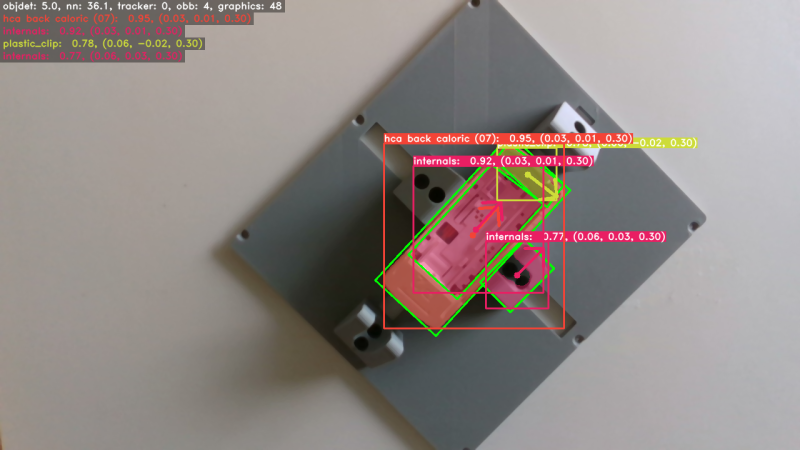

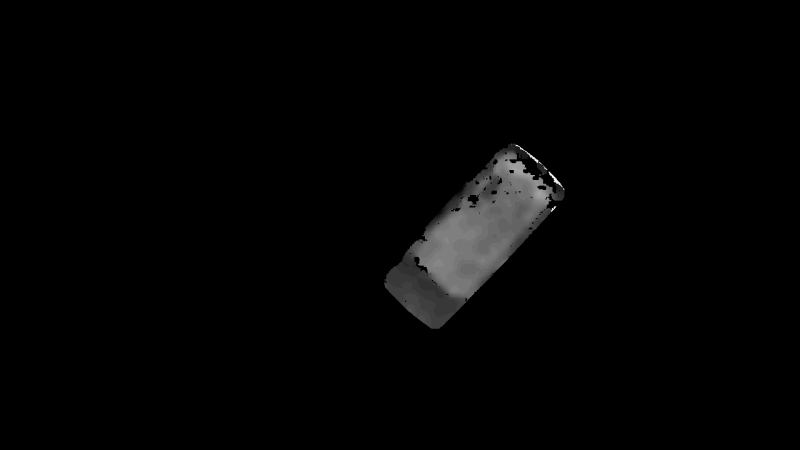

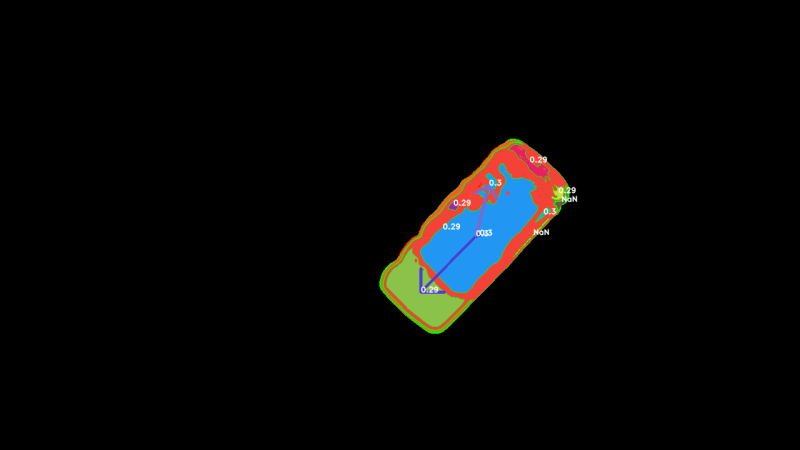

classify: kalo, 03, conf: 0.5055922865867615

elapsed_time_classify_and_rot 0.043797445483505726

depth mean 0.29822, median 0.297

median depth: 0.322

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:131: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


num points thresholded 0

TODO: implement removing of outliers

gap detector, depth_min: 0.28600000000000003

gap detector, depth_min_nonzero: 0.28600000000000003

gap detector, depth_median_nonzero: 0.301

gap detector, depth_max: 0.321

gap detector, num clusters: 3

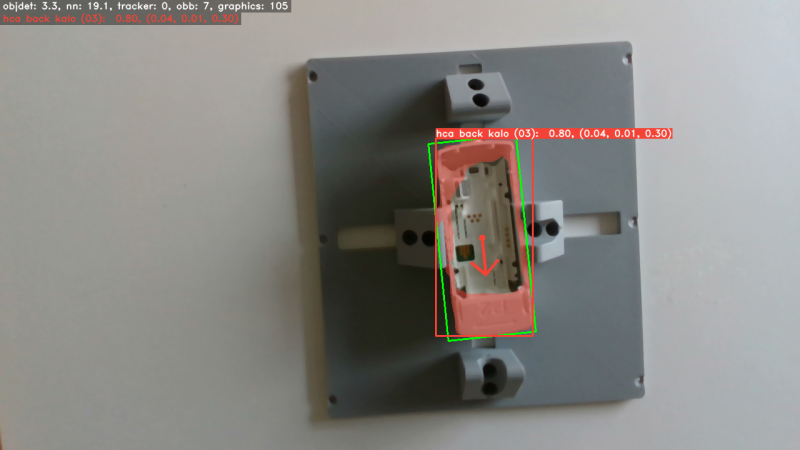

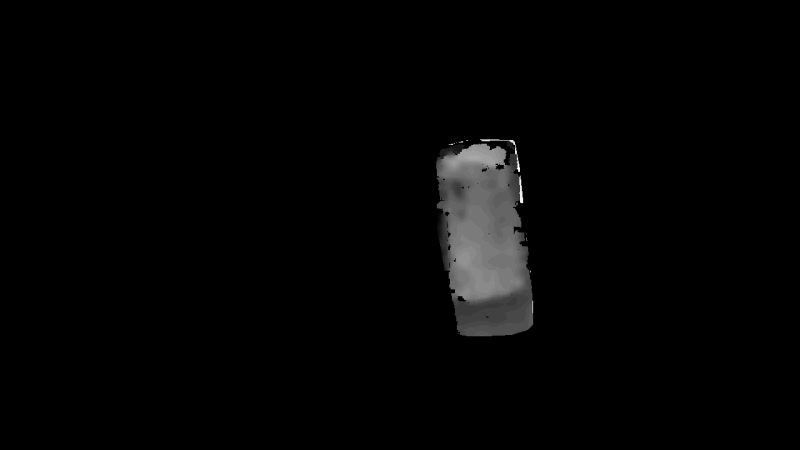

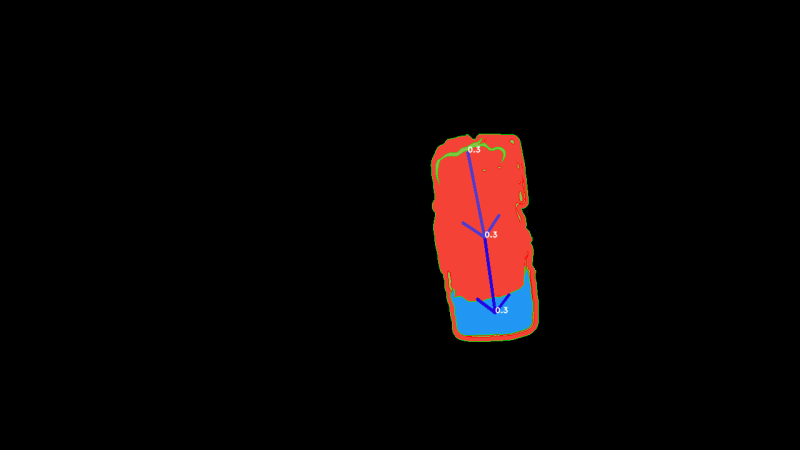

depth mean 0.3742, median 0.375

median depth: 0.397

gap detector: detection_hca_back is None!

UnboundLocalError: local variable 'depth_masked_ma' referenced before assignment

In [23]:
for file_name_without_ext in file_names_without_ext:
    colour_img, depth_vis_img, depth_img, camera_info = load_depth_data_from_filename(file_name_without_ext, images_dir)
    
    labelled_img, depth_scaled, cluster_img = run_gap_detection(colour_img, depth_img, camera_info)

    display(PILImage.fromarray(scale_img(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB))))

    display(PILImage.fromarray(scale_img(cv2.cvtColor(depth_scaled, cv2.COLOR_BGR2RGB))))

    display(PILImage.fromarray(scale_img(cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB))))


classify: kalo, 03, conf: 0.8571254014968872

elapsed_time_classify_and_rot 0.023186558857560158

depth mean 0.30419, median 0.303

depth mean 0.30164, median 0.302

depth mean 0.29644, median 0.297

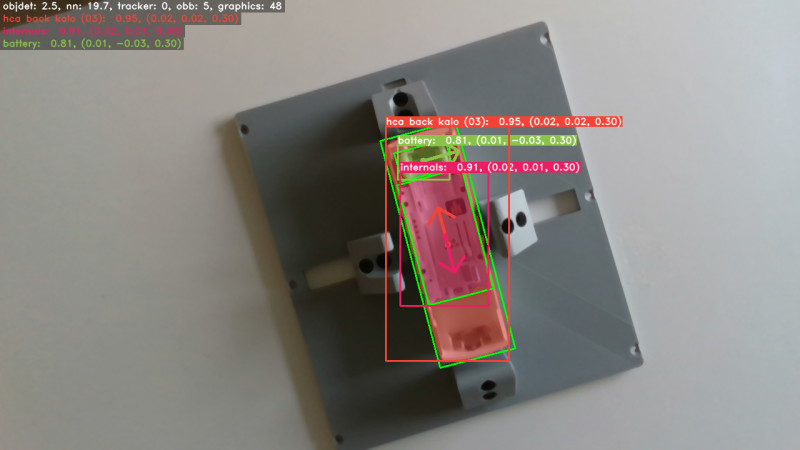

graph: Device 1: internals in hca, battery in hca, battery next to internals.

list_wc_components
[{0, 1, 2}]

detections 3

median depth: 0.322

num points thresholded 0

TODO: implement removing of outliers

gap detector, depth_min: 0.28800000000000003

gap detector, depth_min_nonzero: 0.28800000000000003

gap detector, depth_median_nonzero: 0.302

gap detector, depth_max: 0.322

x.shape
(51684, 2)

y.shape
(51684,)

deth_scaled min 0

deth_scaled max 255

gap detector, num clusters: 11

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


depth_scaled_masked:

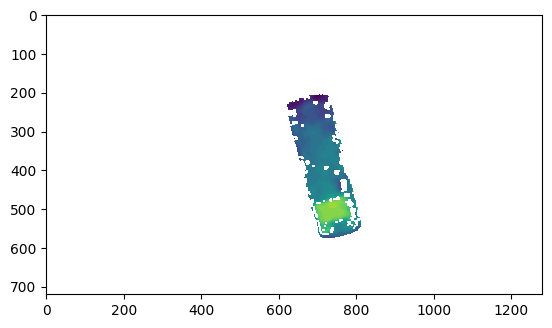

Gaussian blur on depth_scaled:

depth_gaussian: maxLoc
(740, 489)

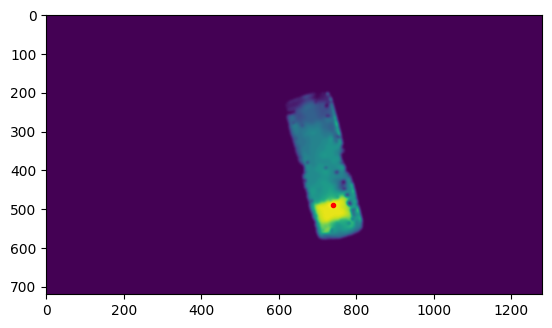

np.min(depth_grad) -19.5

np.max(depth_grad) 16.0

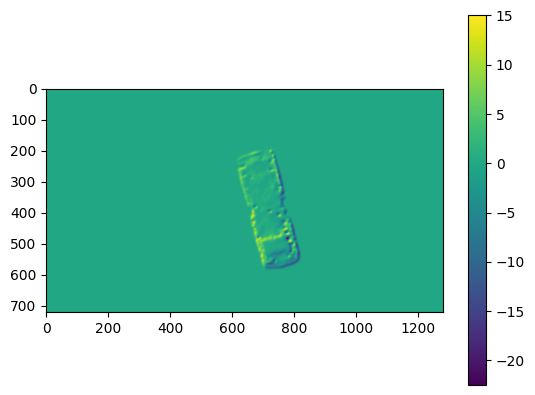

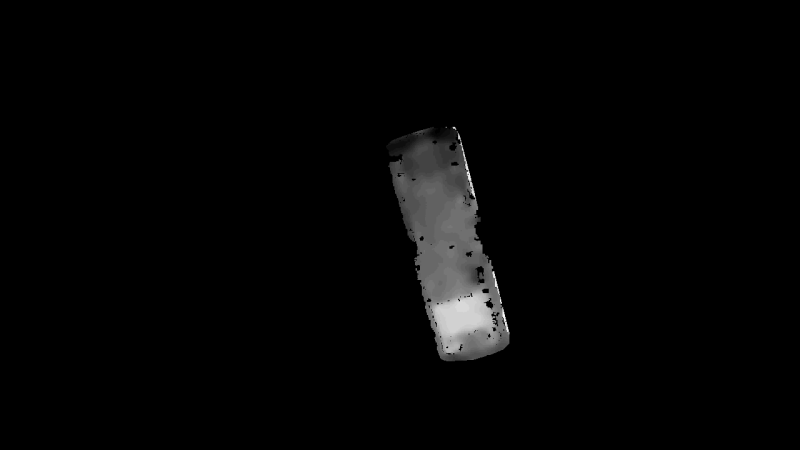

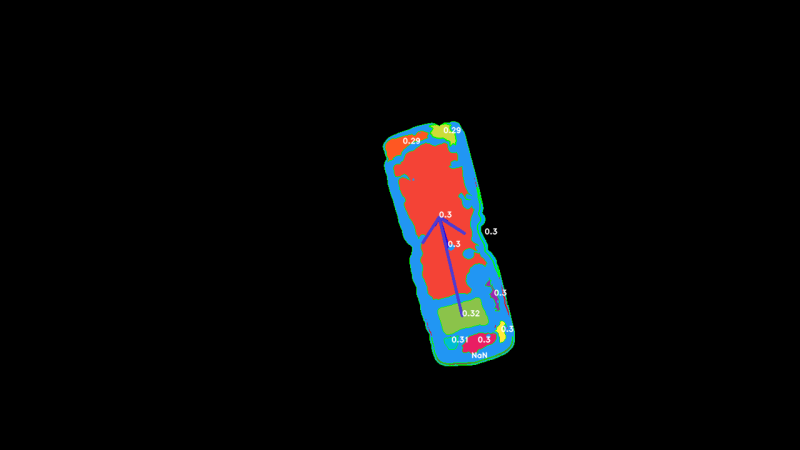

In [10]:

# TODO: 1. load the depth, and camera info
# TODO: 2. run the detections
# TODO: 3. get the clustering


labelled_img, detections, markers, poses, graph_img, graph_relations = object_detection.get_prediction(colour_img, depth_img=depth_img, worksurface_detection=None, extra_text=None, camera_info=camera_info, use_tracker=False, use_classify=True)

#! specify use_classify=True if you want it to classify and estimate rotation

display(PILImage.fromarray(scale_img(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB))))

if depth_img is not None:
    gaps, cluster_img, device_mask, depth_masked_ma, depth_scaled, depth_scaled_masked \
        = gap_detector.lever_detector(
            colour_img,
            depth_img,
            detections,
            graph_relations,
            camera_info
        )

# plt.imshow(labelled_img)
# plt.show()


graph_relations_text = graph_relations.to_text()
print("graph:", graph_relations_text)
print("list_wc_components", graph_relations.list_wc_components)
print("detections", len(detections))

# print("detections", detections)


    # print("gaps", gaps)

# print("depth_scaled:")

# plt.imshow(depth_scaled)
# plt.show()

print("depth_scaled_masked:")

plt.imshow(depth_scaled_masked)
plt.show()

#################################################################
from skimage.filters import threshold_otsu

print("Gaussian blur on depth_scaled:")

depth_gaussian = cv2.GaussianBlur(depth_scaled, (21, 21), 0)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(depth_gaussian)

print("depth_gaussian: maxLoc", maxLoc)

plt.imshow(depth_gaussian)
plt.plot(maxLoc[0], maxLoc[1], 'r.')
plt.show()

# _, image2 = cv2.threshold(depth_gaussian, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# print("depth_scaled_masked.shape", depth_scaled_masked.shape)
# print("min depth_scaled_masked", np.min(depth_scaled_masked))
# print("max depth_scaled_masked", np.max(depth_scaled_masked))
# print("median depth_scaled_masked", np.median(depth_scaled_masked))

# otsu_threshold = threshold_otsu(depth_scaled)

# binary_otsu = depth_scaled > otsu_threshold

# print("otsu thresholding:")
# plt.imshow(binary_otsu)
# plt.show()


##################################################################
# import hdbscan

# hdbscan_fit = hdbscan.HDBSCAN(min_cluster_size=20).fit_predict(depth_scaled)

# print("len(hdbscan_fit)", len(hdbscan_fit))

# plt.imshow(hdbscan_fit)
# plt.show()

###################################################################
# https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_holes_and_peaks.html

# from skimage.morphology import reconstruction

# seed = np.copy(depth_scaled)
# seed[1:-1, 1:-1] = depth_scaled.max()
# mask = depth_scaled

# filled = reconstruction(seed, mask, method='erosion')

# print("skimage reconstruction")

# plt.imshow(filled)
# plt.show()


###################################################################
# from scipy.ndimage.filters import maximum_filter
# from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
# from skimage.feature import peak_local_max

# def detect_peaks(image):
#     """
#     Takes an image and detect the peaks usingthe local maximum filter.
#     Returns a boolean mask of the peaks (i.e. 1 when
#     the pixel's value is the neighborhood maximum, 0 otherwise)
#     """

#     # define an 8-connected neighborhood
#     neighborhood = generate_binary_structure(2,2)

#     print("neighborhood.shape", neighborhood.shape)

#     #apply the local maximum filter; all pixel of maximal value 
#     #in their neighborhood are set to 1
#     max_filter = maximum_filter(image, size=4)
#     # max_filter = maximum_filter(image, footprint=neighborhood)
#     local_max = max_filter == image
#     #local_max is a mask that contains the peaks we are 
#     #looking for, but also the background.
#     #In order to isolate the peaks we must remove the background from the mask.

#     j, i = np.where(local_max)
#     coordinates_2 = np.array(zip(i,j))
#     print("coordinates_2.shape", coordinates_2.shape)


#     # coordinates = peak_local_max(image, min_distance=20)


#     print("max filter:")
#     plt.imshow(max_filter)
#     # plt.plot(coordinates_2[:, 0], coordinates_2[:, 1], 'r.')
#     plt.show()

#     print("local max:")
#     plt.imshow(local_max)
#     plt.show()


#     #we create the mask of the background
#     background = (image==0)

#     #a little technicality: we must erode the background in order to 
#     #successfully subtract it form local_max, otherwise a line will 
#     #appear along the background border (artifact of the local maximum filter)
#     eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

#     #we obtain the final mask, containing only peaks, 
#     #by removing the background from the local_max mask (xor operation)
#     detected_peaks = local_max ^ eroded_background

#     return detected_peaks

# peak_dets = detect_peaks(depth_scaled)



# plt.imshow(peak_dets)
# plt.show()

##########################################################

# from scipy.signal import argrelextrema
# local_max = argrelextrema(depth_scaled, np.greater)

# print("local_max", local_max)

# print("depth_scaled.shape", depth_scaled.shape)

############################################################

depth_grad = np.gradient(depth_gaussian) # a list of two arrays

print("np.min(depth_grad)", np.min(depth_grad))
print("np.max(depth_grad)", np.max(depth_grad))

grad_total = depth_grad[0] + depth_grad[1]
# print("depth_scaled", depth_scaled.shape)

plt.imshow(grad_total)
plt.colorbar()
plt.show()

# plt.imshow(depth_grad[0])
# plt.colorbar()
# plt.show()

# plt.imshow(depth_grad[1])
# plt.colorbar()
# plt.show()

##############################################################


# display(PILImage.fromarray(scale_img(cv2.cvtColor(depth_grad, cv2.COLOR_BGR2RGB))))

display(PILImage.fromarray(scale_img(cv2.cvtColor(depth_scaled, cv2.COLOR_BGR2RGB))))

# display(PILImage.fromarray(cv2.cvtColor(depth_masked, cv2.COLOR_BGR2RGB)))


display(PILImage.fromarray(scale_img(cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB))))


# ! How about this: 
# https://stackoverflow.com/questions/62745825/2d-local-maxima-and-minima-in-python
# cv2.filter2D

# https://stackoverflow.com/questions/77109279/how-do-i-locate-minima-in-an-array

# https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array
